# Adversarial attacks on GoogleNet
The goal of this notebook is to download a pretrained GoogleNet model for classifying CIFAR-10 images, test it on our dataset, then generate adversarial examples and see if they fool the GoogleNet model. Then we'll try transfer-training the GoogleNet model with these adversarial images to see if that makes the network robust against them, and what the accuracy cost is.

The pretrained model and the GoogLeNet class are provided by [Huy Phan](https://github.com/huyvnphan/PyTorch_CIFAR10).

In [1]:
%pylab inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import imageio
# Model path:
PATH = '../Models/googlenet_cifar10.pth'

Populating the interactive namespace from numpy and matplotlib


In [9]:
class GoogLeNet(nn.Module):

    ## CIFAR10: aux_logits True->False
    def __init__(self, num_classes=10, aux_logits=False, transform_input=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        
        ## CIFAR10: out_channels 64->192, kernel_size 7->3, stride 2->1, padding 3->1
        self.conv1 = BasicConv2d(3, 192, kernel_size=3, stride=1, padding=1)
#         self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
#         self.conv2 = BasicConv2d(64, 64, kernel_size=1)
#         self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
#         self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        ## END

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        
        ## CIFAR10: padding 0->1, ciel_model True->False
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=False)
        ## END

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        
        ## CIFAR10: kernel_size 2->3, padding 0->1, ciel_model True->False
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=False)
        ## END
        
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

#         if init_weights:
#             self._initialize_weights()

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 import scipy.stats as stats
#                 X = stats.truncnorm(-2, 2, scale=0.01)
#                 values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
#                 values = values.view(m.weight.size())
#                 with torch.no_grad():
#                     m.weight.copy_(values)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)

        # N x 3 x 224 x 224
        x = self.conv1(x)
        
        ## CIFAR10
        # N x 64 x 112 x 112
#         x = self.maxpool1(x)
        # N x 64 x 56 x 56
#         x = self.conv2(x)
        # N x 64 x 56 x 56
#         x = self.conv3(x)
        # N x 192 x 56 x 56
#         x = self.maxpool2(x)
        ## END

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return _GoogLeNetOuputs(x, aux2, aux1)
        return x

    

class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = x.view(x.size(0), -1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 2048
        x = F.dropout(x, 0.7, training=self.training)
        # N x 2048
        x = self.fc2(x)
        # N x 1024

        return x
    
    
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:
transforms.Normalize()

In [56]:
tmean = [0.4914, 0.4822, 0.4465]
tstd = [0.2023, 0.1994, 0.2010]
transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(tmean, tstd)])

inv_normalize = transforms.Normalize(
    mean=[-1*tmean[i]/tstd[i] for i in range(3)],
    std=[1/tstd[i] for i in range(3)]
)

batchsize = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../Data', train=True,
                                        download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def imshowt(img):
    img = inv_normalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
gnet = GoogLeNet()
state_dict = torch.load('../Models/googlenet.pt')
gnet.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
def predict_image(network, input_tensor):
    """
    Input: Image tensor
    Outputs: Predicted image class, probability assigned by network to top class
    """
    outputs = network(input_tensor)#.squeeze()
    class_probas = nn.Softmax(dim=1)(outputs).detach().cpu().numpy()[0]
    idx = np.argmax(class_probas)
    img_class = classes[idx]
    proba = class_probas[idx]
    return img_class, proba

In [12]:
def get_adversarial_image(network, img_tuple, epsilon=0.01):
    img_file, label = img_tuple
    img = imageio.imread(img_file)
    img_transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = img_transform(img).float().unsqueeze(0).to(device)
    input_tensor.requires_grad = True
    outputs = network(input_tensor)
    # Format label.
    class_name = labels_class[label]
    class_idx = class_names.index(class_name)
    label = torch.tensor(class_idx).unsqueeze(0).to(device)
    # Get loss gradient with regard to image pixels.
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, label)
    loss.backward()
    img_gradient = input_tensor.grad
    gradient_signs = torch.sign(img_gradient).cpu().numpy().squeeze()
    # Match shape of image (channels last in this case)
    gradient_signs = np.transpose(gradient_signs, axes=[1, 2, 0])
    pixel_changes = (gradient_signs * 255 * epsilon).astype(np.int16)
    changed_img = (img).astype(np.int16) + pixel_changes
    adv_img = np.clip(changed_img, 0, 255).astype(np.uint8)
    return adv_img

In [13]:
for i in iter(trainloader):
    image, label = i
    break

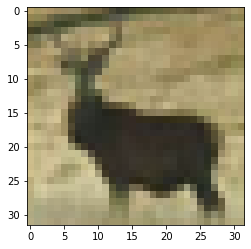

In [58]:
imshowt(image[0]);

In [59]:
predict_image(gnet, image)

('cat', 0.12189901)

In [ ]:
# Predict on the same image samples as above.
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(24, 18))
for i in range(50):
    row = i // 10
    col = i - row * 10
    img = imageio.imread(image_samples[i][0])
    ax[row][col].imshow(img)
    predicted_class, predicted_proba = predict_image(net, img)
    ax[row][col].set_xlabel(f"{predicted_class}: {predicted_proba:.6f}")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])